In [1]:
from transformers import Mask2FormerForUniversalSegmentation, Mask2FormerImageProcessor
import torch
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import os


c:\Users\CE126828\OneDrive - Co-operators\school\Huron-Tissue-Segment\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load the image processor and model for binary semantic segmentation
image_processor = Mask2FormerImageProcessor.from_pretrained("facebook/mask2former-swin-base-ade-semantic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-ade-semantic")

c:\Users\CE126828\OneDrive - Co-operators\school\Huron-Tissue-Segment\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\CE126828\OneDrive - Co-operators\school\Huron-Tissue-Segment\.venv\lib\site-packages\transformers\utils\deprecation.py:165: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)
c:\Users\CE126828\OneDrive - Co-operators\school\Huron-Tissue-Segment\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnin

In [5]:
import numpy as np
from PIL import Image, ImageOps, ImageEnhance
import os

# Define paths
image_folder = "data/Huron_data/Sliced_Images"
mask_folder = "data/Huron_data/Sliced_masks"

# Get sorted lists of the first 200 image and mask files
image_files = sorted(os.listdir(image_folder))[:200]
mask_files = sorted(os.listdir(mask_folder))[:200]

# Load and process images and masks
processed_images = []
processed_masks = []

def crop_black_borders(image, threshold=30):
    """Crop black borders from an image iteratively based on a threshold for black pixels."""
    img_array = np.array(image)
    gray_img = np.mean(img_array, axis=2)  # Convert to grayscale by averaging channels

    # Initialize cropping boundaries
    top, bottom = 0, gray_img.shape[0]
    left, right = 0, gray_img.shape[1]

    # Crop from the top
    while top < bottom and np.mean(gray_img[top, :]) <= threshold:
        top += 1

    # Crop from the bottom
    while bottom > top and np.mean(gray_img[bottom - 1, :]) <= threshold:
        bottom -= 1

    # Crop from the left
    while left < right and np.mean(gray_img[:, left]) <= threshold:
        left += 1

    # Crop from the right
    while right > left and np.mean(gray_img[:, right - 1]) <= threshold:
        right -= 1

    # Crop the image to the calculated bounds
    cropped_image = image.crop((left, top, right, bottom))
    return cropped_image


def preprocess_image(image_path):
    """Preprocess an image: crop black borders and enhance contrast significantly."""
    image = Image.open(image_path).convert("RGB")
    cropped_image = crop_black_borders(image)

    # Significantly enhance contrast
    enhancer = ImageEnhance.Contrast(cropped_image)
    enhanced_image = enhancer.enhance(10) 

    return enhanced_image

def preprocess_mask(mask_path):
    """Convert mask to binary and ensure tissue is white and background is black."""
    mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale
    mask_array = np.array(mask)

    # Apply binary threshold and invert if needed
    binary_mask = np.where(mask_array > 0, 255, 0).astype(np.uint8)  # Ensure tissue is white, background is black
    return Image.fromarray(binary_mask)

# Process images and masks
for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(image_folder, img_file)
    mask_path = os.path.join(mask_folder, mask_file)
    
    # Process and store images
    processed_img = preprocess_image(img_path)
    processed_images.append(processed_img)

    # Process masks and store them
    processed_mask = preprocess_mask(mask_path)
    processed_masks.append(processed_mask)

# `processed_images` is a list of cropped, histogram-equalized, and contrast-enhanced images
# `processed_masks` is a list of binary masks with tissue as white and background as black

In [ ]:
import matplotlib.pyplot as plt



# Ensure correct selection of ground truth masks for evaluation (must be in same order as images)
images_1000 = processed_images  # Keep as PIL.Image objects
masks_1000 = processed_masks 



def verify_data_alignment(original_images, processed_images, masks, num_samples=5):
    """Verify data processing by displaying original images, cropped images, and processed masks from created lists."""
    for i in range(num_samples):
        # Get the images and masks directly from the lists
        original_image = original_images[i]
        processed_image = processed_images[i]
        processed_mask = masks[i]
        
        # Display the original image, cropped image (same as original here), and processed mask side by side
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        
        axs[0].imshow(original_image)
        axs[0].set_title(f"Original Image {i + 1}")
        axs[0].axis("off")
        
        axs[1].imshow(processed_image, cmap="gray")
        axs[1].set_title(f"Processed Image (Post-Processing) {i + 1}")
        axs[1].axis("off")
        
        axs[2].imshow(processed_mask, cmap="gray")
        axs[2].set_title(f"Processed Mask {i + 1}")
        axs[2].axis("off")
        
        plt.show()

# open the original images
original_images = [Image.open(os.path.join(image_folder, img_file)).convert("RGB") for img_file in image_files]
# Run the verification for the first few images and masks
verify_data_alignment(original_images, images_1000, masks_1000, 10)

In [19]:
import torch
import os
from PIL import Image
import cv2
from conch.open_clip_custom import create_model_from_pretrained
from dotenv import load_dotenv

# Load environment variables
# load_dotenv()
# HF_TOKEN = os.getenv("HF_TOKEN")

HF_TOKEN = "..."

# Load the Conch model
def load_model(hf_token):
    model, preprocess = create_model_from_pretrained('conch_ViT-B-16', "hf_hub:MahmoodLab/conch", hf_auth_token=hf_token)
    return model, preprocess

model, preprocess = load_model(HF_TOKEN)

# Function to extract image embeddings
# def image_to_embedding(model, preprocess, image_path):
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = Image.fromarray(image)
#     image = preprocess(image).unsqueeze(0)
#     with torch.inference_mode():
#         image_embs = model.encode_image(image, proj_contrast=False, normalize=False)
#     return image_embs
def image_to_embedding(model, preprocess, image):
    # Assume image is a PIL.Image.Image object
    image = preprocess(image).unsqueeze(0)
    with torch.inference_mode():
        image_embs = model.encode_image(image, proj_contrast=False, normalize=False)
    return image_embs

c:\Users\CE126828\OneDrive - Co-operators\school\Huron-Tissue-Segment\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\CE126828\OneDrive - Co-operators\school\Huron-Tissue-Segment\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\CE126828\OneDrive - Co-operators\school\Huron-Tissue-Segment\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See:

In [20]:
model_encoder, preprocess = load_model(HF_TOKEN)

embeddings = []
for img in processed_images:  # Now, img is a PIL.Image.Image object
    embedding = image_to_embedding(model, preprocess, img)
    embeddings.append(embedding)

c:\Users\CE126828\OneDrive - Co-operators\school\Huron-Tissue-Segment\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\CE126828\OneDrive - Co-operators\school\Huron-Tissue-Segment\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\CE126828\OneDrive - Co-operators\school\Huron-Tissue-Segment\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See:

In [31]:
import torchvision.transforms as transforms

masks_to_tensor = []
transform = transforms.ToTensor()

for img in processed_masks:
    image_tensor = transform(img)
    masks_to_tensor.append(image_tensor)

In [34]:
print(type(masks_to_tensor))
print(len(masks_to_tensor))
print(masks_to_tensor[0].shape)

<class 'list'>
200
torch.Size([1, 512, 512])


In [8]:
print(embeddings[0].shape)

torch.Size([1, 512])


In [42]:
embedding_tensor = torch.tensor(embedding, dtype=torch.float32)  # Shape: [200, 1, 512]
mask_tensor = torch.stack(masks_to_tensor)  # Shape: [200, 1, 512, 512]

C:\Users\CE126828\AppData\Local\Temp\ipykernel_15412\3997198968.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding_tensor = torch.tensor(embedding, dtype=torch.float32)  # Shape: [200, 1, 512]


In [48]:

from transformers import Mask2FormerForUniversalSegmentation
import torch
from torch import nn
import torch.optim as optim

# Load the pretrained model
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-ade-semantic")

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the logits layer in the segmentation head
for param in model.segmentation_head.classifier.parameters():
    param.requires_grad = True

# Set model to training mode
model.train()

# Define optimizer for the unfrozen parameters
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Define a dummy input tensor and target (adjust these to match your actual data)
embedding_tensor = torch.randn(1, 3, 512, 512)  # Example input image tensor
mask_tensor = torch.randint(0, 150, (1, 512, 512))  # Example target mask (for ADE20K's 150 classes)

# Training function
def train_step():
    optimizer.zero_grad()  # Clear previous gradients

    # Forward pass
    outputs = model(embedding_tensor, labels=mask_tensor)

    # Extract the loss
    loss = outputs.loss

    # Backward pass
    loss.backward()  # Corrected typo here

    # Update weights
    optimizer.step()

    return loss.item()

# Run one training step
loss = train_step()
print(f"Training Loss: {loss}")





c:\Users\CE126828\OneDrive - Co-operators\school\Huron-Tissue-Segment\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\CE126828\OneDrive - Co-operators\school\Huron-Tissue-Segment\.venv\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


AttributeError: 'Mask2FormerForUniversalSegmentation' object has no attribute 'segmentation_head'

In [47]:
model.eval() # Set model to evaluation mode

def segment_images_in_batches(images, batch_size=16):
    "Evaluation loop to segment images in batches using the Mask2Former model."
    results = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        inputs = image_processor(images=batch, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        
        results.append(outputs)  # Store outputs directly for post-processing later
    return results

# Process the 200 images in batches (adjust batch size as needed)
segmentation_results = segment_images_in_batches(images_1000, batch_size=16)

KeyboardInterrupt: 

In [ ]:
def post_process_outputs(outputs):
    " Extract binary masks from segmentation results that are in raw logits form."
    masks = []
    for output in outputs:
        # Assuming outputs is a list of dictionaries, and each output has "masks_queries_logits" for binary masks
        # Retrieve the mask logits instead of class logits
        mask_logits = output.masks_queries_logits  # Check if this key exists in the output

        if mask_logits is None:
            print("No mask logits found in output.")
            continue
        # Apply thresholding or argmax to extract the relevant binary mask
        # Assuming the first query represents the background and the second represents "tissue"
        # Change logic if more classes or queries are present in your case
        binary_mask = (mask_logits[:, 1] > 0.5).cpu().numpy().astype(np.uint8)  # Threshold for binary segmentation

        masks.append(binary_mask)  # Append the binary mask
    
    return masks

# Extract binary masks from segmentation results
binary_masks_1000 = post_process_outputs(segmentation_results)

In [58]:
import numpy as np
from PIL import Image

def iou_score(pred, target):
    # Ensure binary format (0 or 1) and uint8 type
    pred = (pred > 0).astype(np.uint8)
    target = (target > 0).astype(np.uint8)

    intersection = np.logical_and(pred, target)
    union = np.logical_or(pred, target)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 1.0
    return iou

def dice_score(pred, target):
    # Ensure binary format (0 or 1) and uint8 type
    pred = (pred > 0).astype(np.uint8)
    target = (target > 0).astype(np.uint8)

    intersection = np.sum(pred * target)
    dice = (2. * intersection) / (np.sum(pred) + np.sum(target)) if (np.sum(pred) + np.sum(target)) > 0 else 1.0
    return dice

def resize_mask(mask, target_shape=(512, 512)):
    """Resize the mask to the target shape using nearest neighbor interpolation."""
    # Remove extra dimensions and ensure uint8 format
    mask = np.squeeze(mask).astype(np.uint8)

    # Convert to PIL Image, resize, and convert back to numpy array
    if mask.ndim == 3 and mask.shape[2] == 3:  # If the mask is RGB
        mask = Image.fromarray(mask).convert("L")  # Convert to grayscale
    elif mask.ndim == 2:
        mask = Image.fromarray(mask)  # Already grayscale
    else:
        raise ValueError(f"Unexpected mask shape after squeezing: {mask.shape}")

    # Resize the mask
    resized_mask = mask.resize(target_shape, Image.NEAREST)
    return np.array(resized_mask)

def invert_mask(mask):
    """Invert a binary mask (0 becomes 255 and vice versa)."""
    return np.where(mask == 0, 255, 0).astype(np.uint8)

def evaluate_segmentation(predicted_masks, ground_truth_masks, target_shape=(512, 512)):
    """Evaluate segmentation masks using IoU and Dice metrics."""
    iou_scores = []
    dice_scores = []

    for idx, (pred, target) in enumerate(zip(predicted_masks, ground_truth_masks)):
        # If `pred` has a batch dimension, select the first mask in the batch
        if pred.ndim == 3:  # Check for batch dimension
            pred = pred[0]  # Take only the first mask in the batch

        # Resize both predicted and target masks to the target shape
        pred_resized = resize_mask(pred, target_shape)
        target_resized = resize_mask(np.array(target), target_shape)
        target_resized = invert_mask(target_resized)

        # Ensure binary format
        pred_binary = (pred_resized > 0).astype(np.uint8)
        target_binary = (target_resized > 0).astype(np.uint8)

    

        # Calculate IoU and Dice for each mask
        iou = iou_score(pred_binary, target_binary)
        dice = dice_score(pred_binary, target_binary)

        # Store the scores
        iou_scores.append(iou)
        dice_scores.append(dice)

    # Calculate average scores
    avg_iou = np.mean(iou_scores) if iou_scores else 0
    avg_dice = np.mean(dice_scores) if dice_scores else 0

    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Average Dice Coefficient: {avg_dice:.4f}")

    return iou_scores, dice_scores

# Run the evaluation with debugging
iou_scores, dice_scores = evaluate_segmentation(binary_masks_1000, masks_1000, target_shape=(512, 512))


print("\n\nIoU: State-of-the-art scores range from 0.75 to 0.85+ depending on the dataset and complexity. ")
print("Dice Score: High-performing models generally achieve 0.8 to 0.9+, with top models reaching above 0.9 on simpler tasks or well-defined regions.")


Average IoU: 0.5978
Average Dice Coefficient: 0.6893


IoU: State-of-the-art scores range from 0.75 to 0.85+ depending on the dataset and complexity. 
Dice Score: High-performing models generally achieve 0.8 to 0.9+, with top models reaching above 0.9 on simpler tasks or well-defined regions.


In [52]:
import matplotlib.pyplot as plt

def verify_alignment(images, predicted_masks, ground_truth_masks, num_samples=20):
    """Display up to `num_samples` to visually check alignment of predicted and ground truth masks."""
    count = 0
    for i in range(len(predicted_masks)):
        if count >= num_samples:
            break

        # Handle batched masks
        batch_pred = predicted_masks[i]
        if batch_pred.ndim == 3:
            # If there is a batch dimension, loop through each mask in the batch
            for mask_idx in range(batch_pred.shape[0]):
                if count >= num_samples:
                    break

                # Display the image, predicted mask, and ground truth mask side by side
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                
                axs[0].imshow(images[count])
                axs[0].set_title(f"Image {count + 1}")
                axs[0].axis('off')
                
                axs[1].imshow(invert_mask(batch_pred[mask_idx]), cmap='gray', vmin=0, vmax=1)
                axs[1].set_title(f"Predicted Mask {count + 1}")
                axs[1].axis('off')
                
                axs[2].imshow(ground_truth_masks[count], cmap='gray', vmin=0, vmax=1)
                axs[2].set_title(f"Ground Truth Mask {count + 1}")
                axs[2].axis('off')
                
                plt.show()
                count += 1
        else:
            # If no batch dimension, display directly
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            
            axs[0].imshow(processed_images[count])
            axs[0].set_title(f"Image {count + 1}")
            axs[0].axis('off')
            
            axs[1].imshow(batch_pred, cmap='gray', vmin=0, vmax=1)
            axs[1].set_title(f"Predicted Mask {count + 1}")
            axs[1].axis('off')
            
            axs[2].imshow(ground_truth_masks[count], cmap='gray', vmin=0, vmax=1)
            axs[2].set_title(f"Ground Truth Mask {count + 1}")
            axs[2].axis('off')
            
            plt.show()
            count += 1

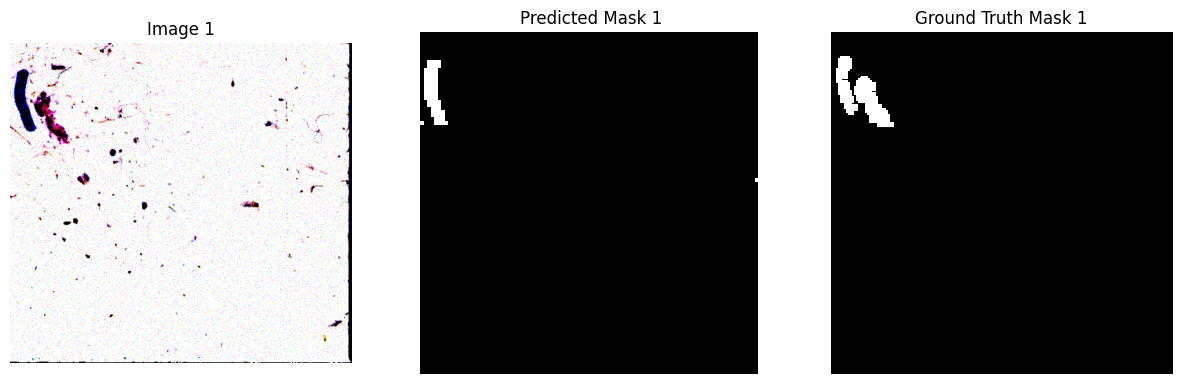

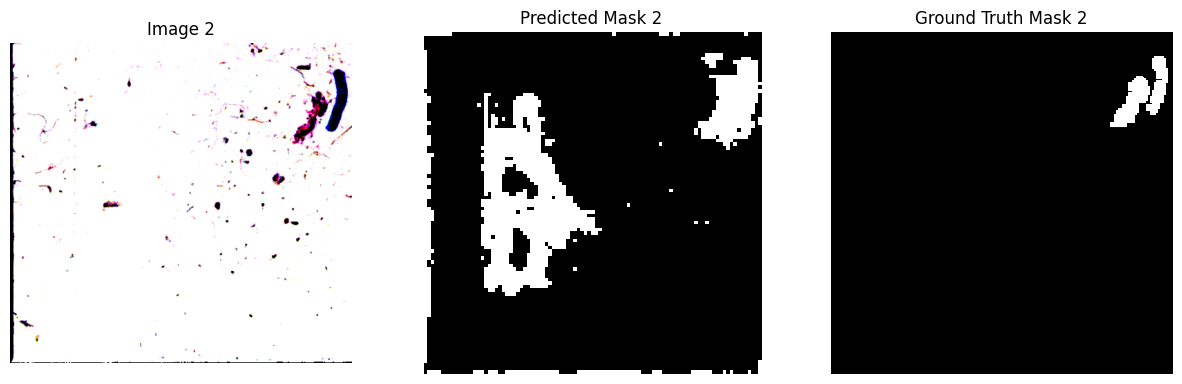

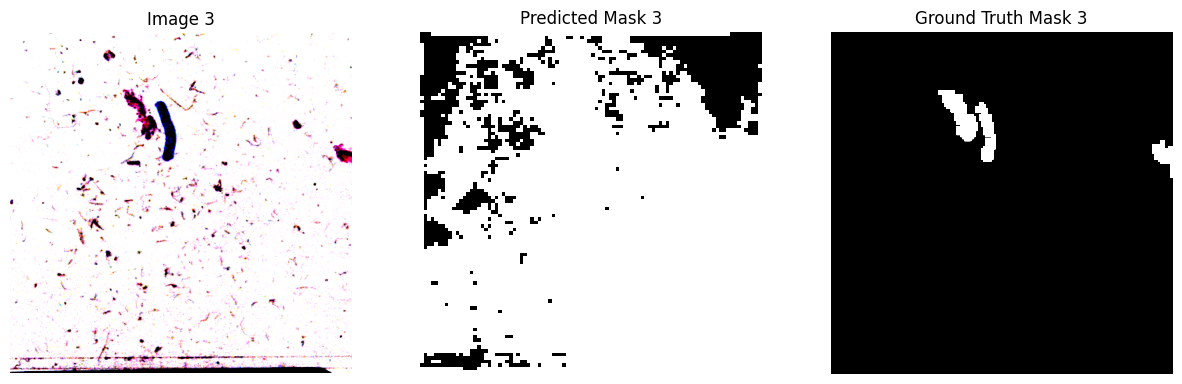

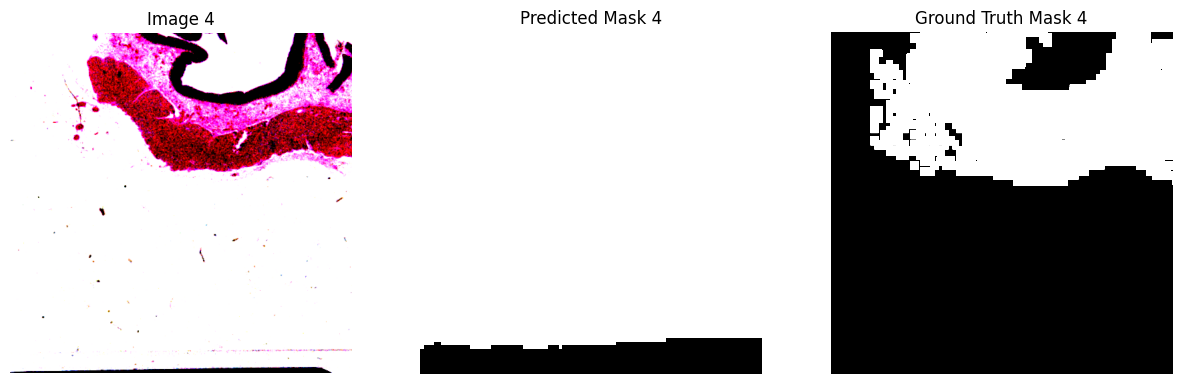

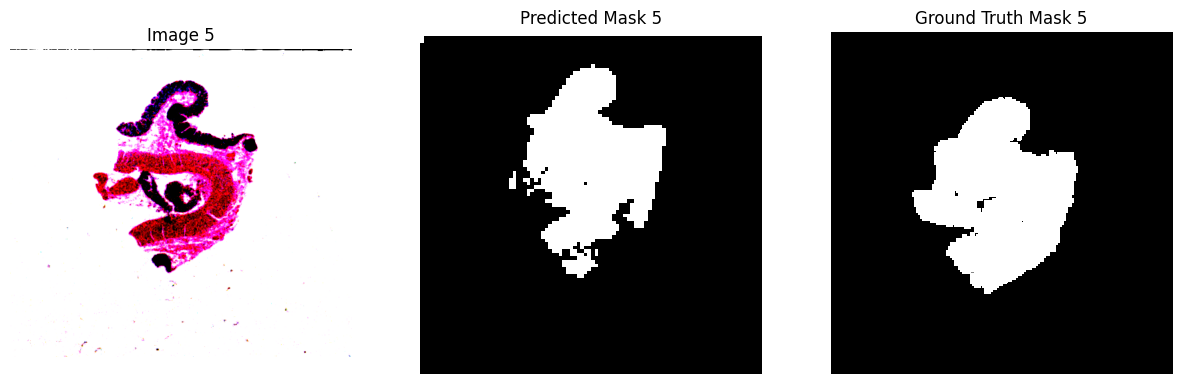

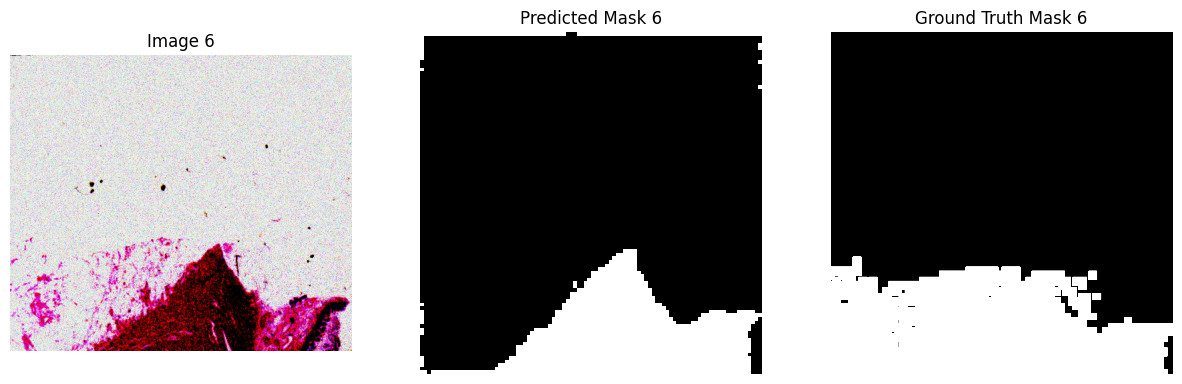

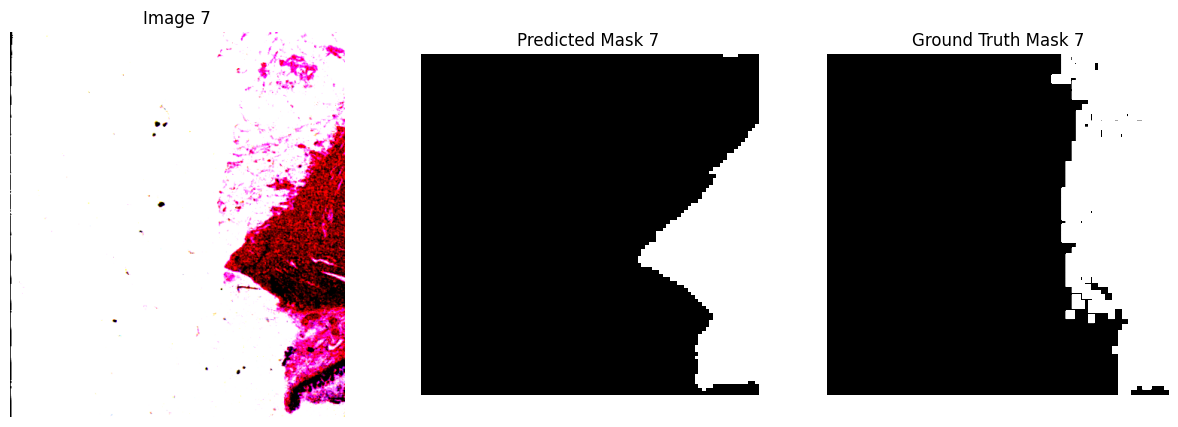

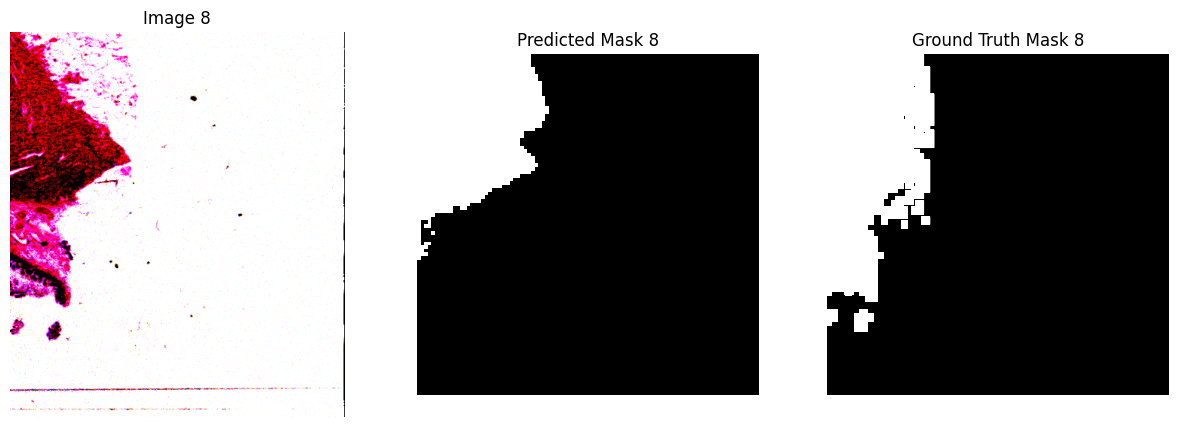

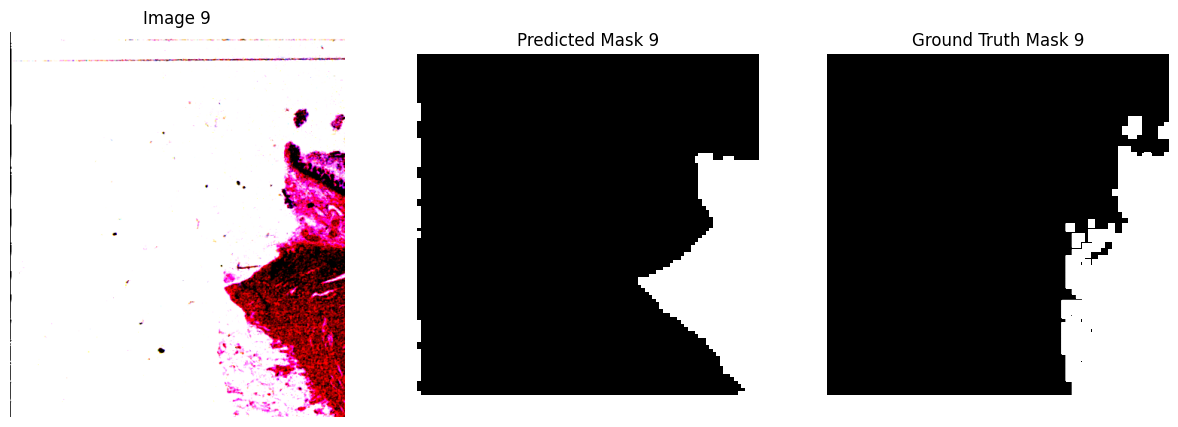

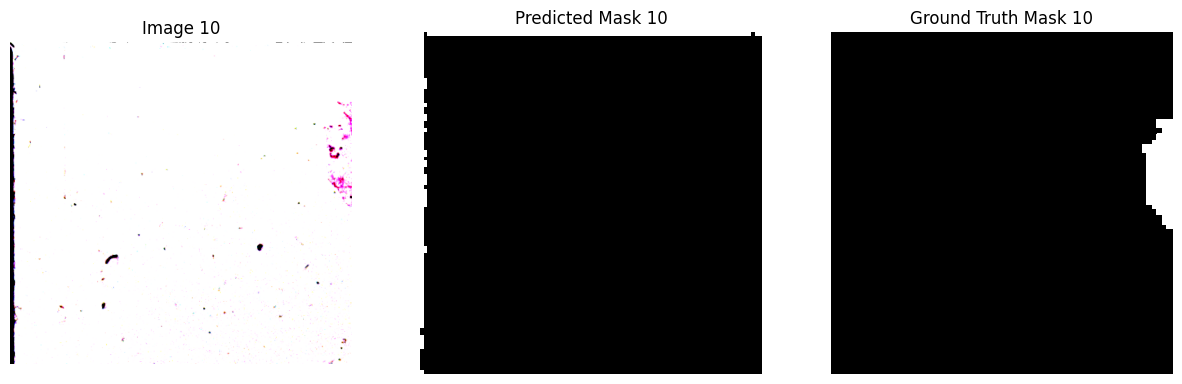

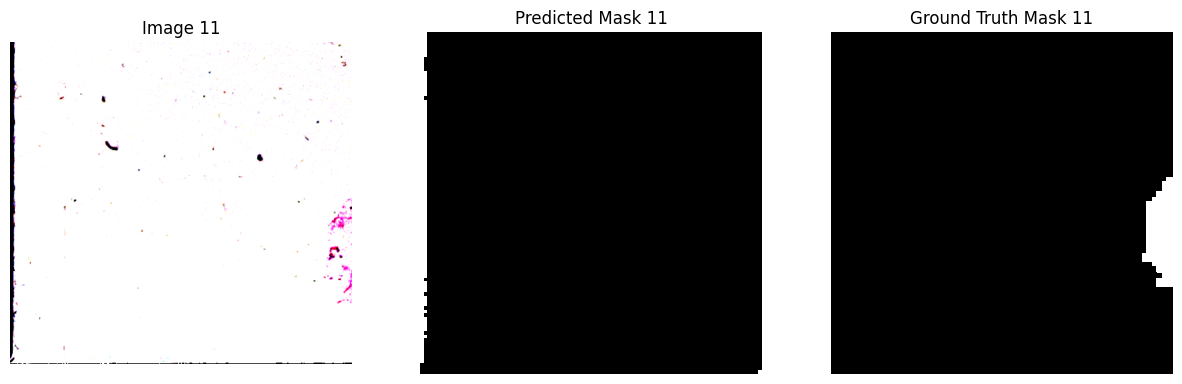

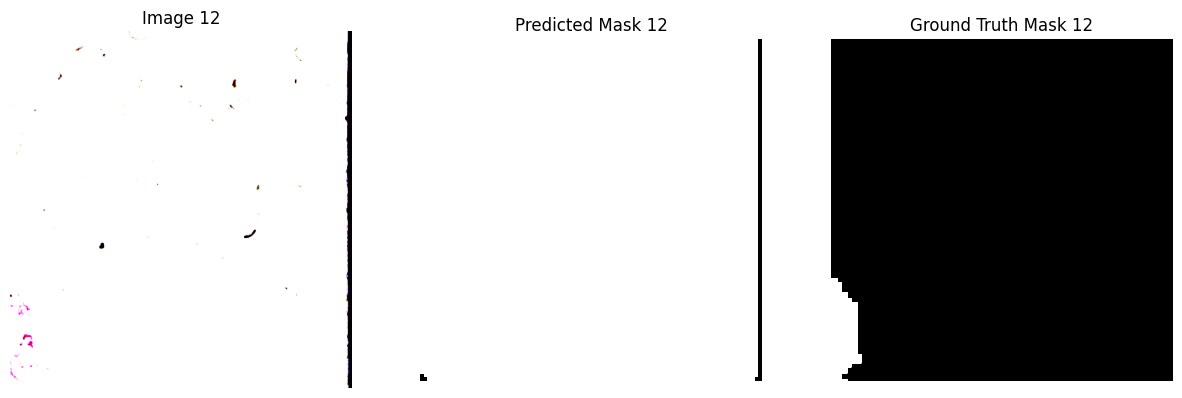

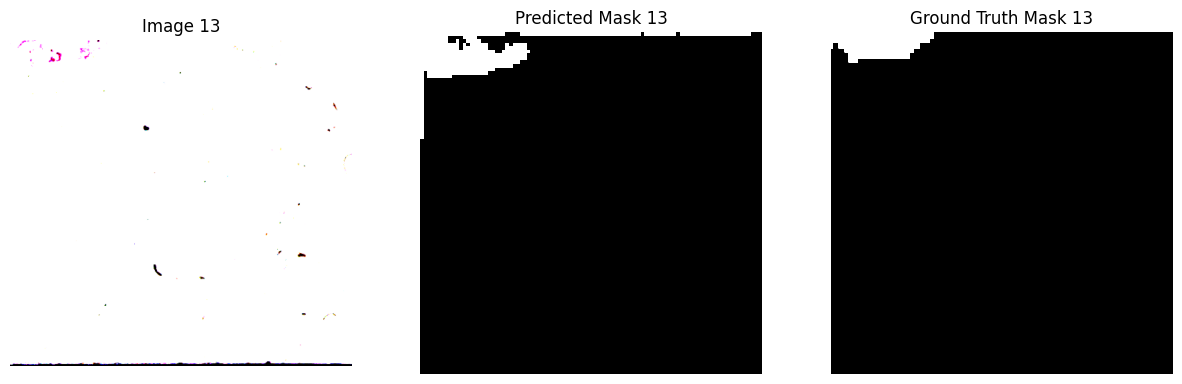

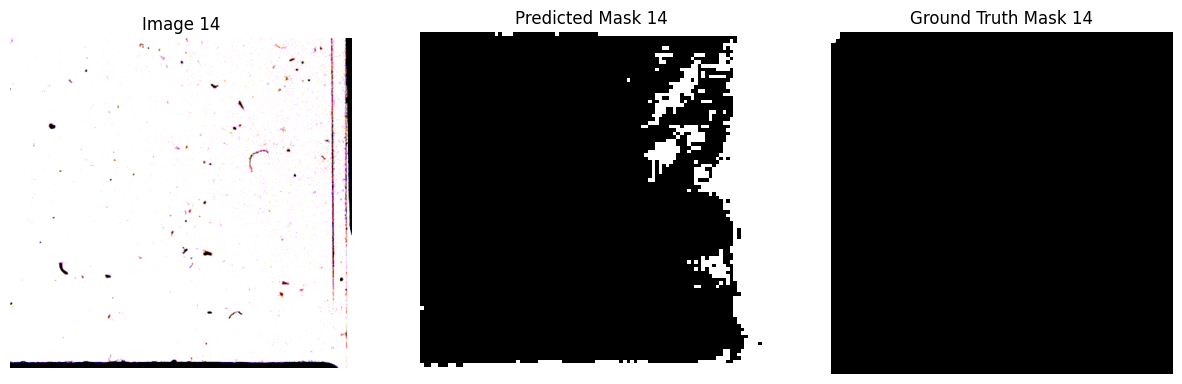

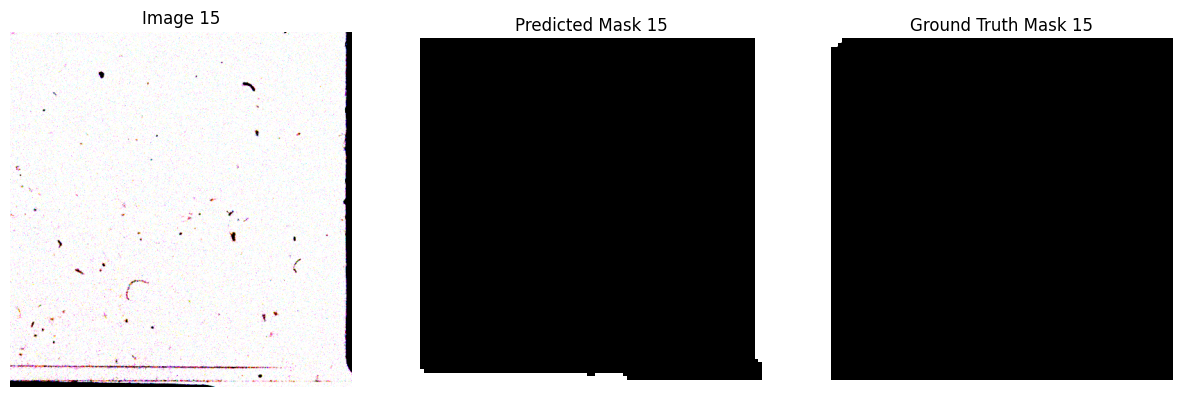

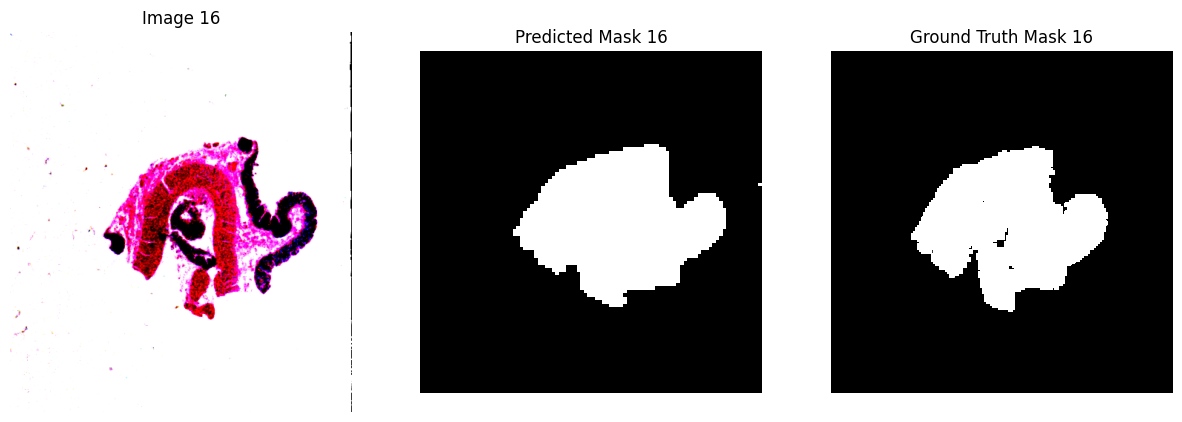

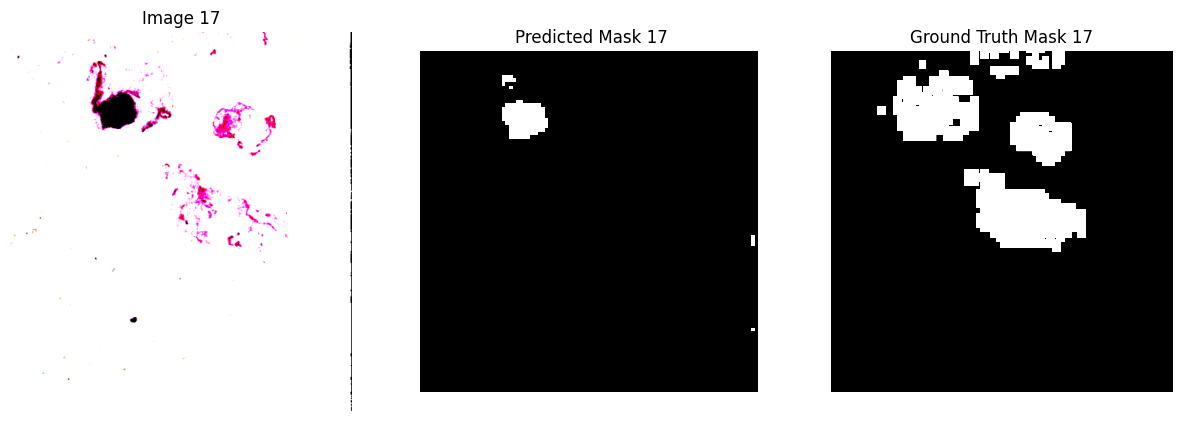

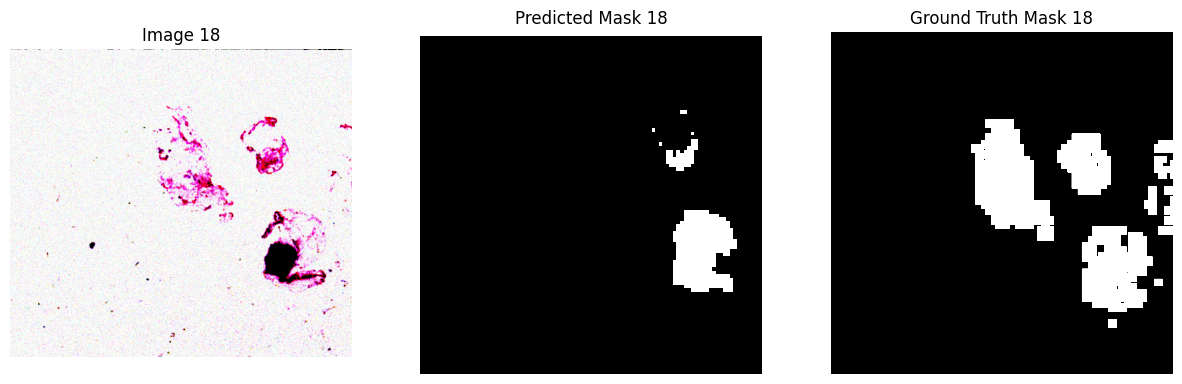

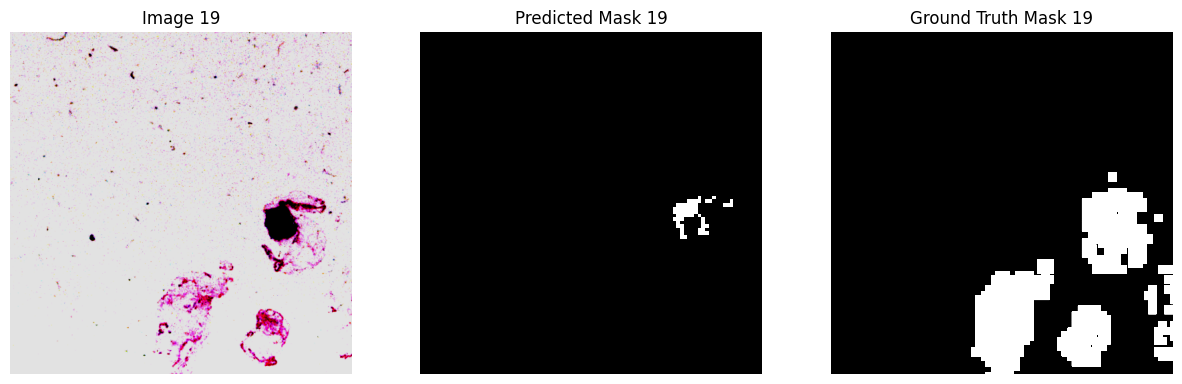

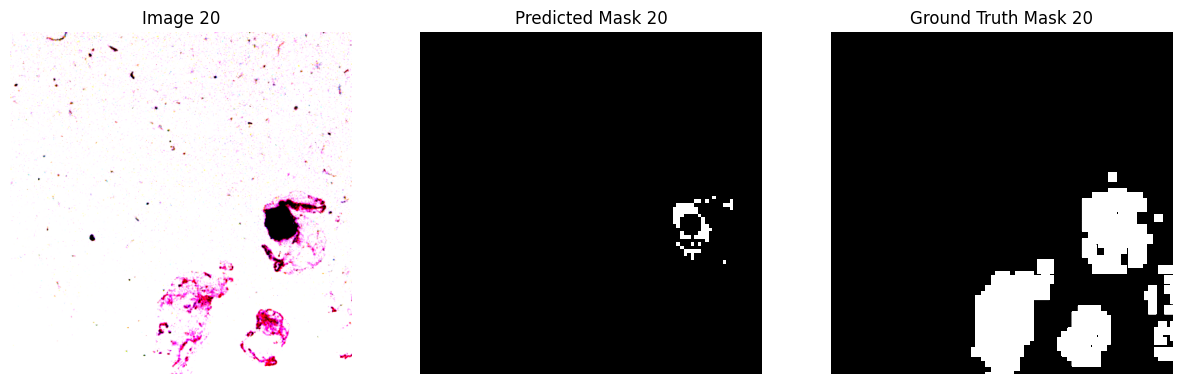

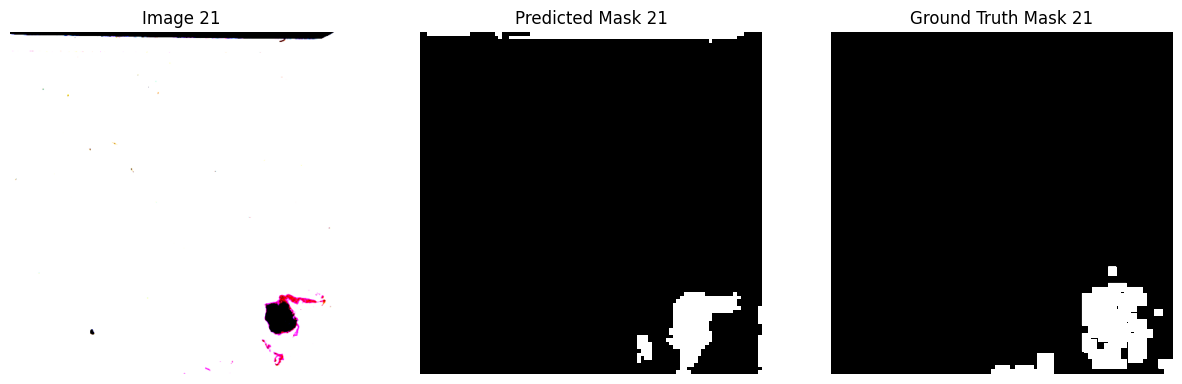

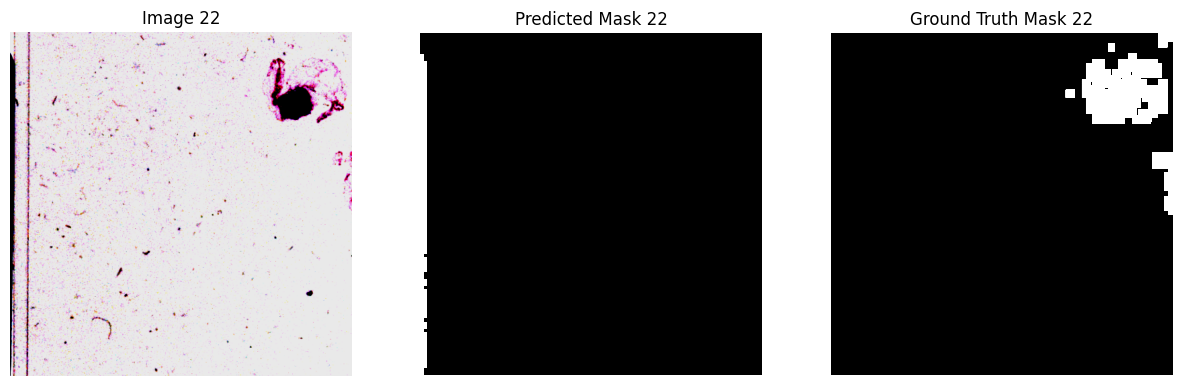

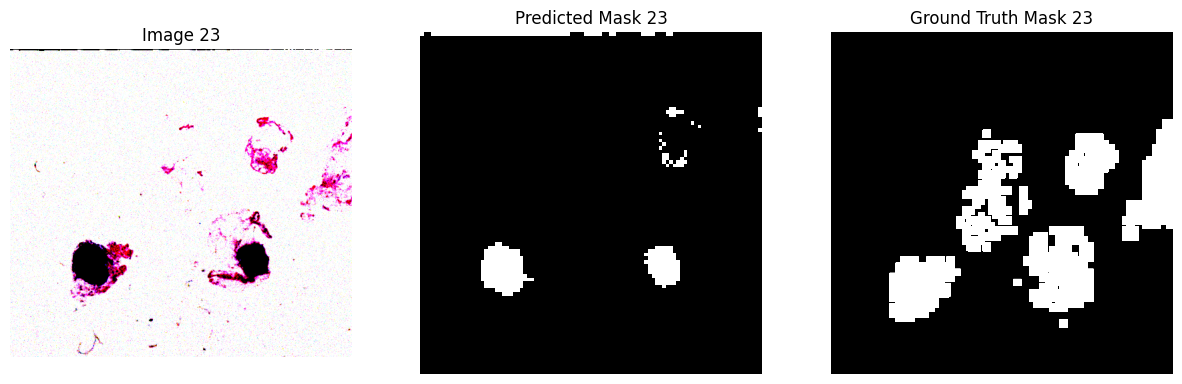

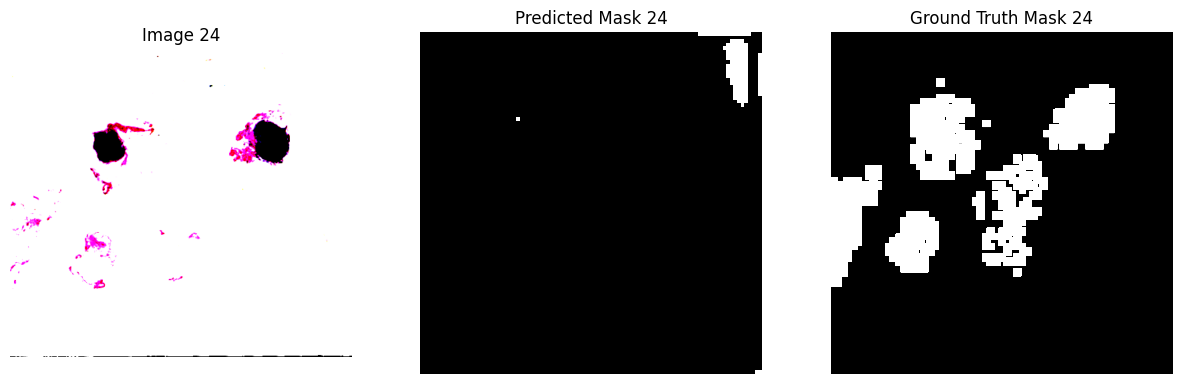

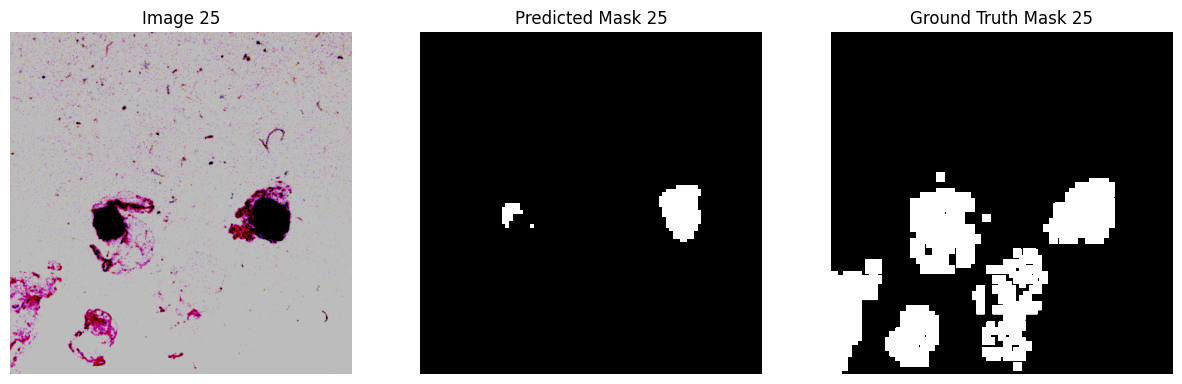

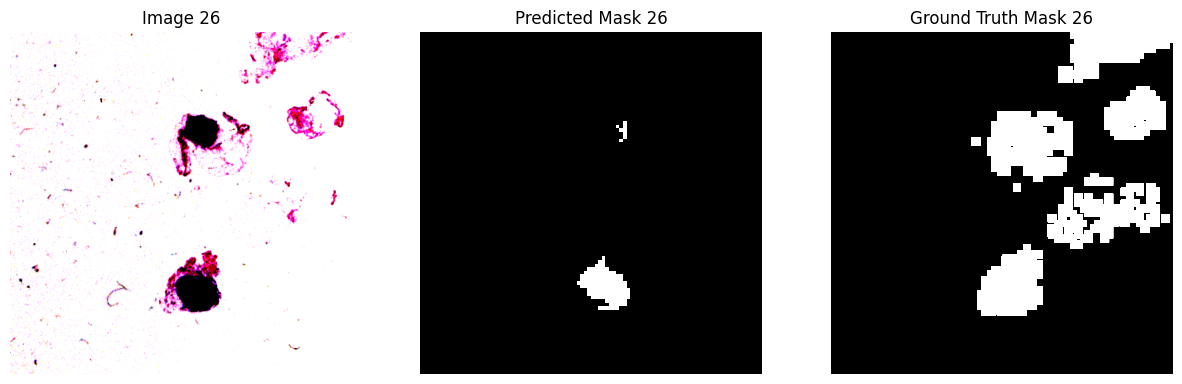

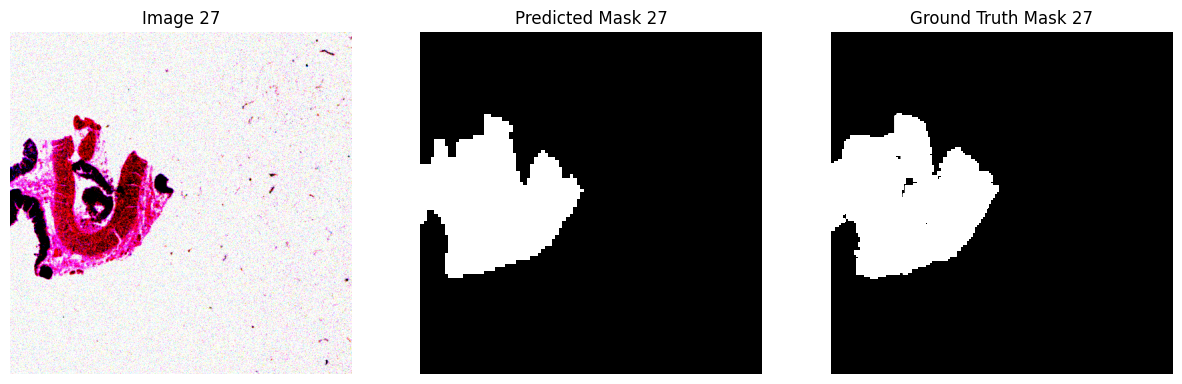

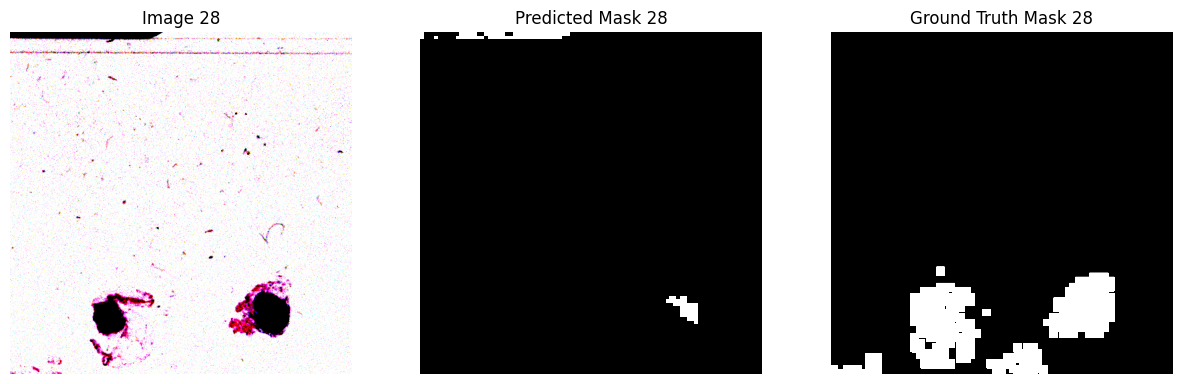

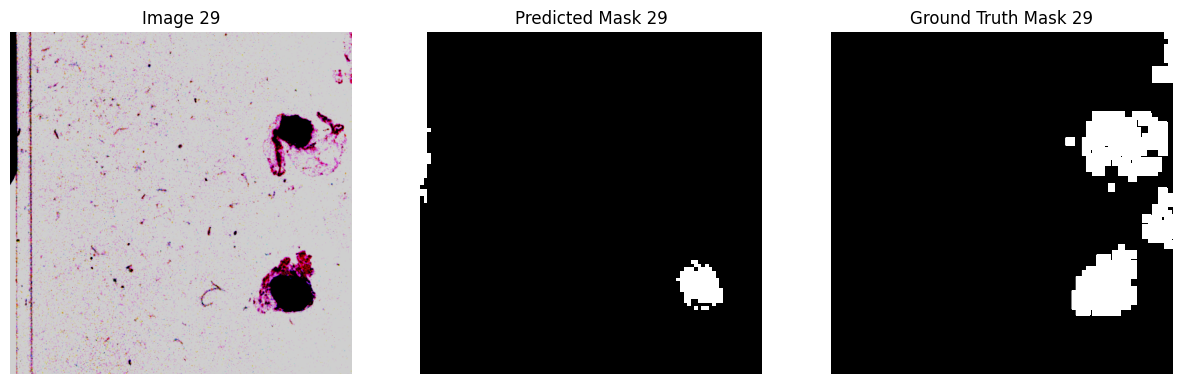

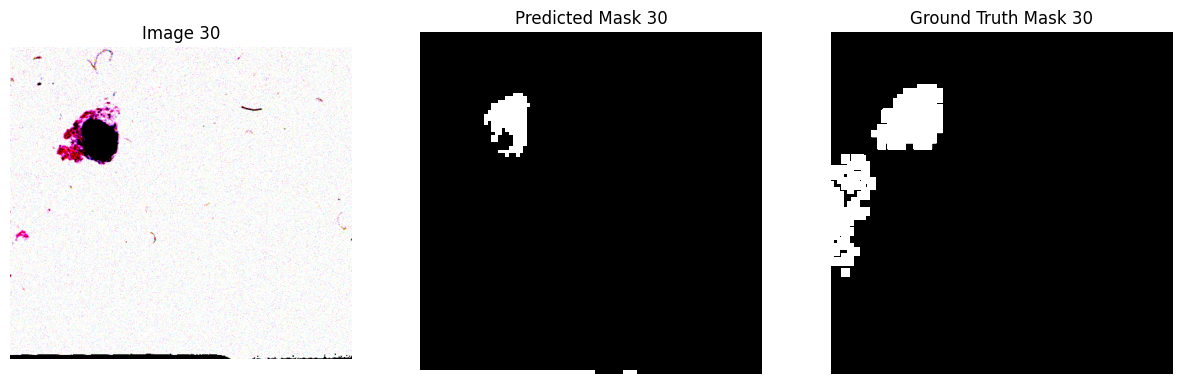

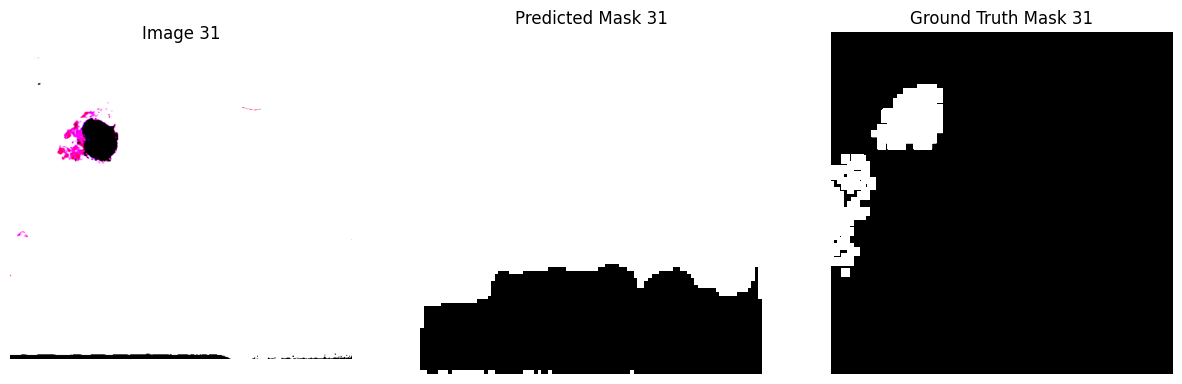

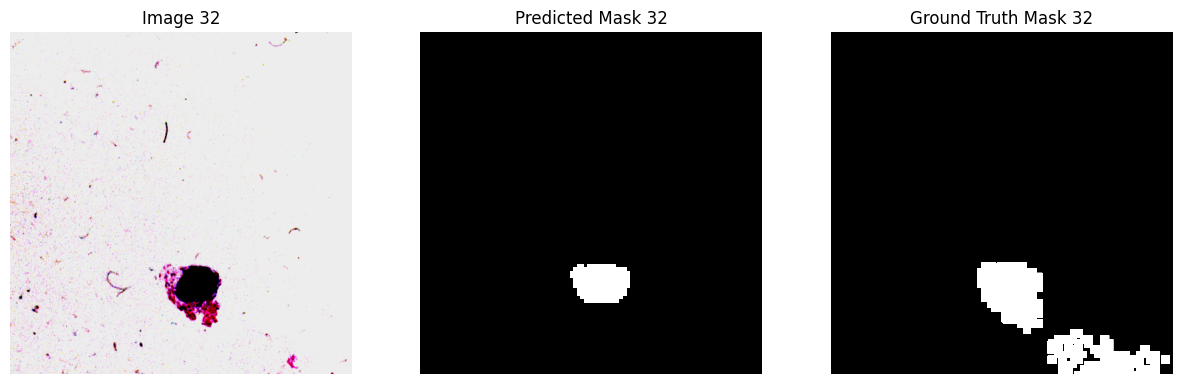

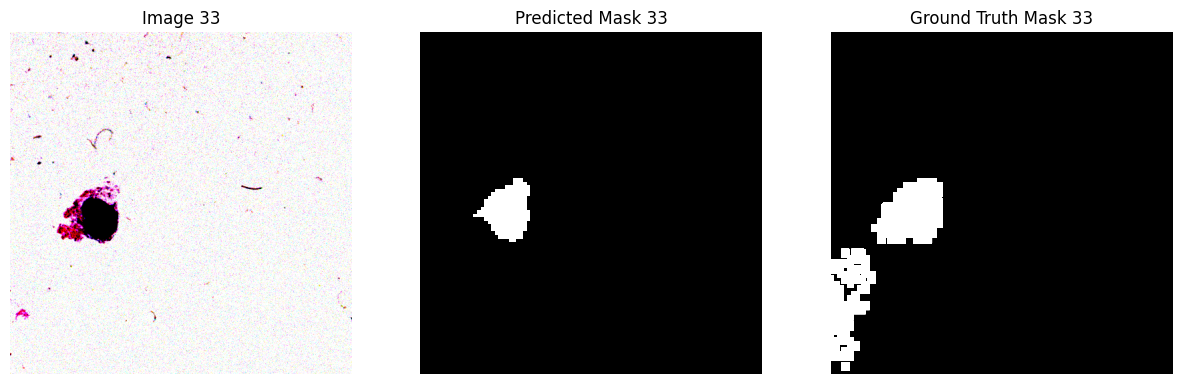

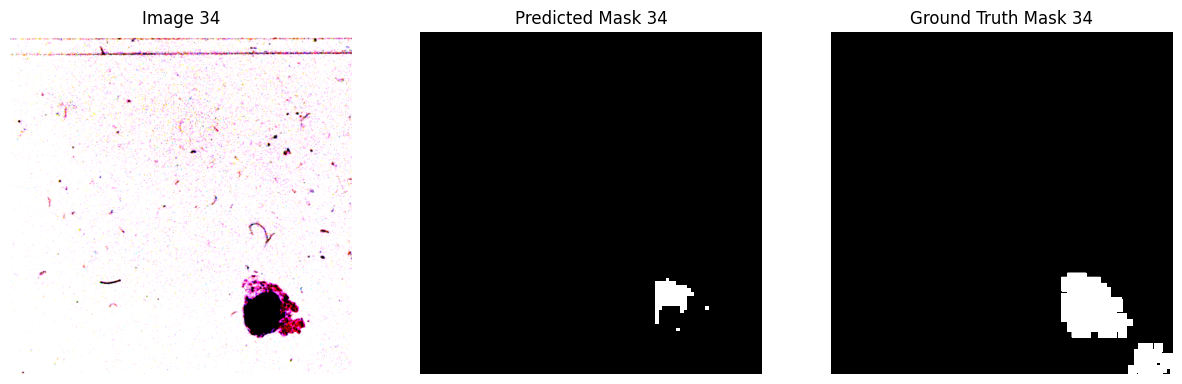

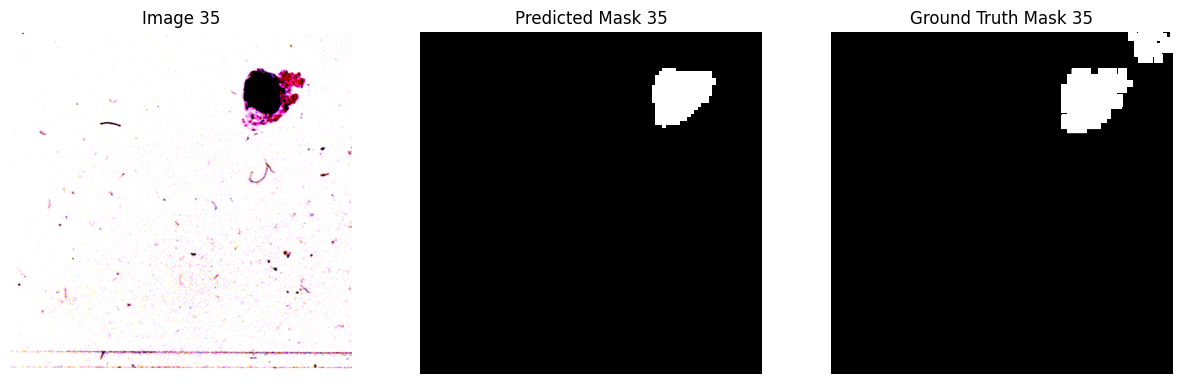

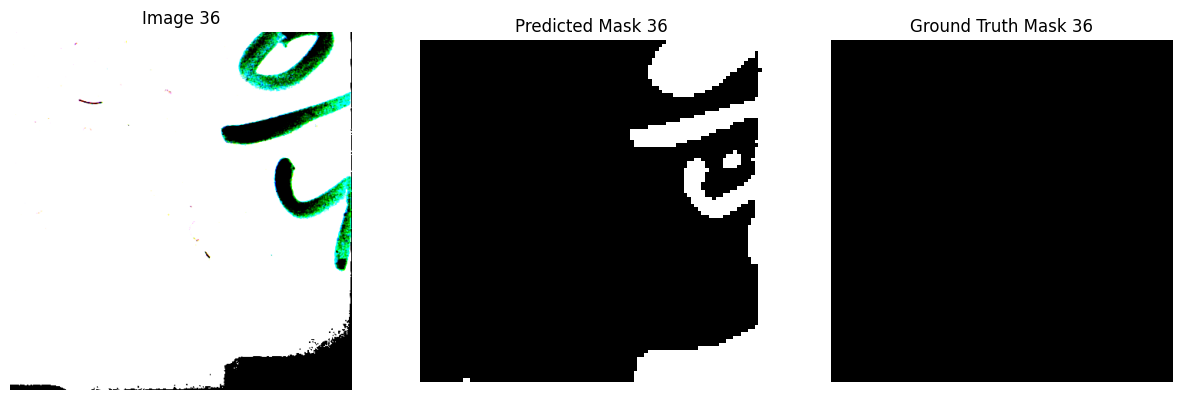

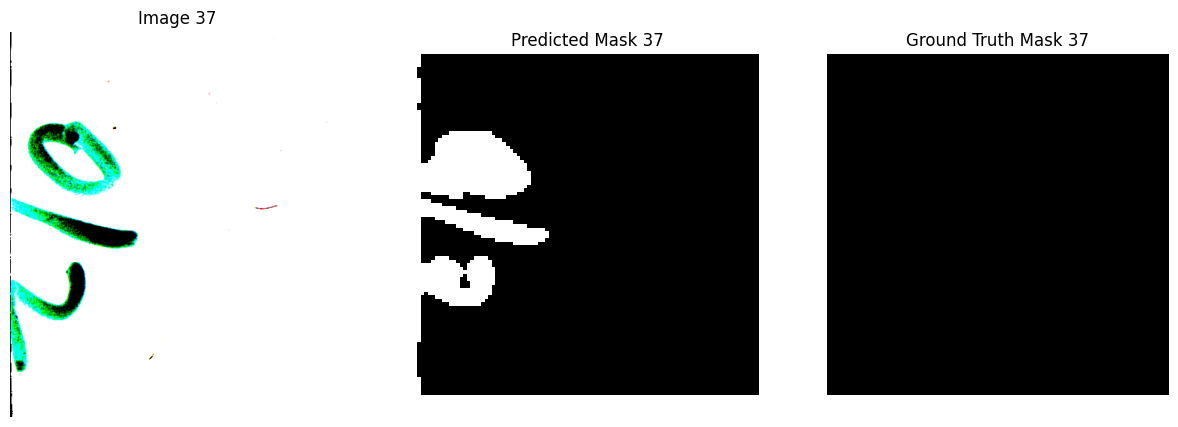

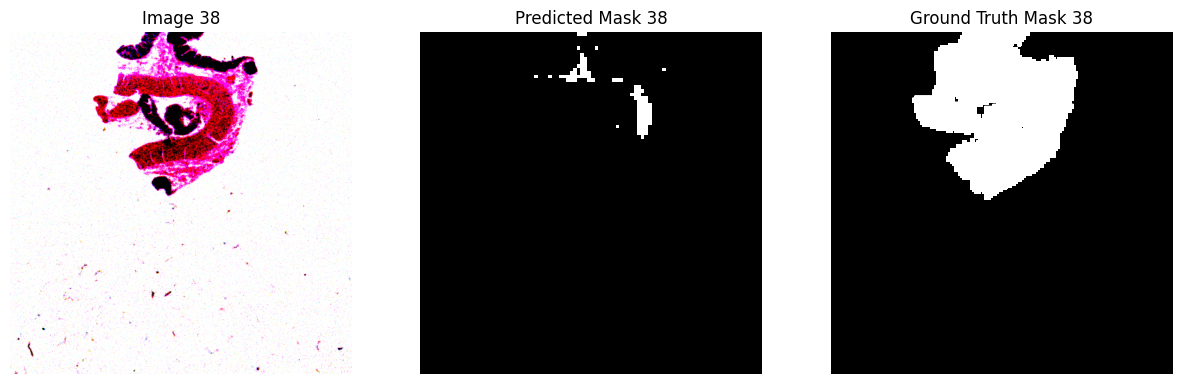

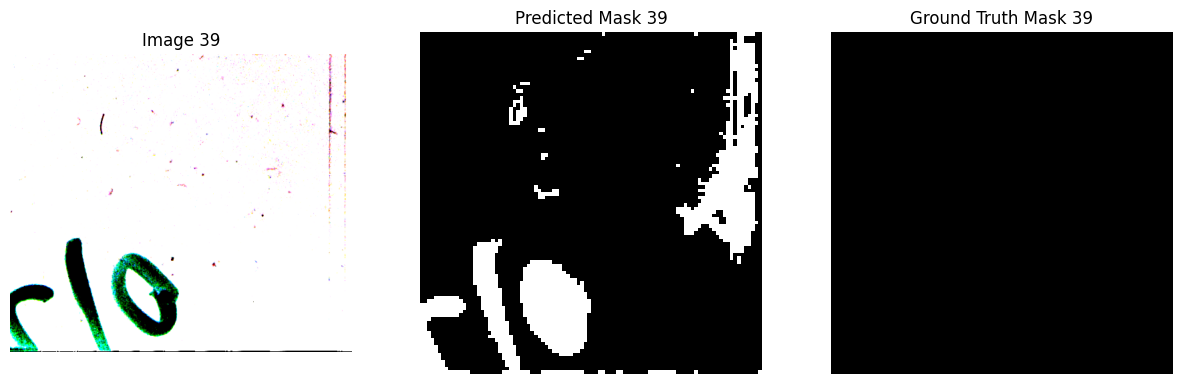

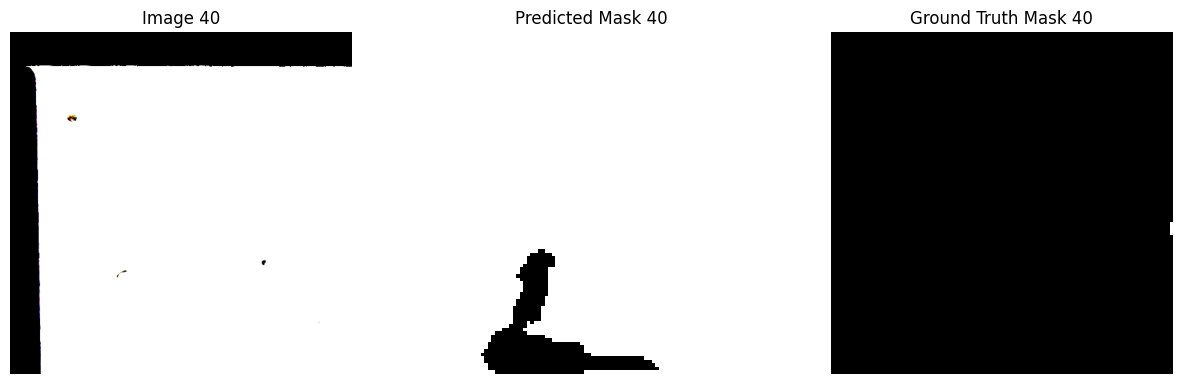

In [53]:
verify_alignment(images_1000, binary_masks_1000, masks_1000, num_samples=40)